# Basic Instructions

1. Enter your Name, UID and Link to Google Drive in the provided space.
2. Submit the assignment to Gradescope.
3. Do not change anything unless told to do so by the instructions. We give you a framework, and until Exercise 10, you should adhere to that framework as closely as possible.

Final Submission Deadline: May 11, 5:00pm

Name:  **Sumedh Koppula**  
UID:  **117386066**

Link to Google Drive : **https://colab.research.google.com/drive/1xUYxsdmV3iVZRpMP-ARfCekU5zA5Aiqa?usp=sharing**

## Preliminaries (IMPORTANT, MUST READ)

This assignment is meant to enrich your understanding of VAEs based on what was covered in lecture.

This assignment is all bonus, but some of it should be considered "core" components, and we will give no credit unless they are all in working order. These components are represented by Exercises 1-5. For example, if you complete Exercises 1-4 only, you will receive no credit for this assignment. Together, they are worth **50%** of the points for this assignment.

Exercises 6-10, on the other hand, are **extra** components. You may complete any number of these to increase the number of bonus points you receive for the assignment. Together, they allow you to earn the other **50%** of the points, but note that they can be completed cafeteria style -- pick whatever seems edible and eat it. No need to buy/eat everything, unless you really want to. Doing extra exercises will not increase your grade for the assignment: **hard cap at 100%**.

Consider 5 students, A, B, C, D, and E.

Student A completes Exercises 1-4. They get a 0.

Student B completes 1-5. They get a 50.

Student C completes 1-6. They get a 60.

Student D completes 1-5, 7, 9, and 10. They get a 100.

Student E completes 1-10. They also get a 100.


Imports and Parameter Settings
-------------------

In [ ]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 326322032.89it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31710914.61it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 188034023.83it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2616471.47it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Exercise 1: Define Encoder
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

<font color="red"> TODO: complete Encoder forward (3-5 lines of code) </font>

In [ ]:
 class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        cap = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=cap, kernel_size=4, stride=2, padding=1) # out: capacity x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=cap, out_channels=cap*2, kernel_size=4, stride=2, padding=1) # out: capacity x 7 x 7
        self.fc_mu = nn.Linear(in_features=cap*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=cap*2*7*7, out_features=latent_dims)

    def forward(self, x):
        ### TODO: implement forward
        ## hint: use relu as activation for each conv layer
        ## hint: flatten after self.conv2
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

Exercise 2: Define Decoder
-----------------------

<font color="red"> TODO: complete Decoder init (3-4 lines of code) </font>

In [ ]:

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        cap = capacity
        ### TODO: define Decoder
        ## hint: define an FC layer with the appropriate number of in_channels for the output of the encoder
        ## hint: fc out_channels need to provide what self.conv2 expects
        #self.fc = ...
        self.fc = nn.Linear(in_features=latent_dims, out_features=cap*2*7*7)
        ## hint: two up-conv layers that are essentially the converse of the original convolutional layers
        #self.conv2 = nn.ConvTranspose2d(...)
        #self.conv1 = ...
        self.conv2 = nn.ConvTranspose2d(in_channels=cap*2, out_channels=cap, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=cap, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

Exercise 3: Define Variational Autoencoder
-----------------------

<font color="red"> TODO: complete VAE init (2 lines of code) </font>

<font color="red"> TODO: complete VAE forward (2 lines of code) </font>

<font color="red"> TODO: complete VAE latent_sample (2 lines of code) </font>

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        ### TODO: implement constructor, set encoder and decoder
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        ### TODO: finish implementation of forward
        ## hint: call encoder
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        ## hint: call decoder
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            ### TODO: implement the missing parts of the reparameterization trick
            ## hint: calculate std
            std = torch.exp(0.5 * logvar)
            ## hint: calculate eps
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

Exercise 4: Define VAE Loss
-----------------------
VAE loss is a linear combination of the reconstruction loss (computed as BCE between original and reconstructed image) and the KL-Divergence between the prior distriubtrion over latent vectors and the distribution estimated by the gerenated for the given image. Here, we give you the KL term and the combintation, but have you implement the reconstruction loss.

<font color="red"> TODO: Reconstruction loss (1 line of code) </font>

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.

    ### TODO: define recon_loss
    ## hint: use binary cross entropy
    ## hint: use reduction='sum' argument
    ## hint: flatten both images to shape (1, 784)
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')


    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

Exercise 5: Train VAE
--------
<font color="red"> TODO: complete training loop (3 lines of code) </font>

In [ ]:
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)
assert num_params == 308357

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        ## hint: send images to gpu (if using)
        image_batch = image_batch.to(device)

        ## hint: pass images through vae
        recon_images, mu, logvar = vae(image_batch)

        ## hint: compute reconstruction error (calculate loss)
        loss = vae_loss(recon_images, image_batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Number of parameters: 308357
Training ...
Epoch [1 / 100] average reconstruction error: 23331.035885
Epoch [2 / 100] average reconstruction error: 21012.361062
Epoch [3 / 100] average reconstruction error: 20458.582887
Epoch [4 / 100] average reconstruction error: 20162.439441
Epoch [5 / 100] average reconstruction error: 19970.611426
Epoch [6 / 100] average reconstruction error: 19836.093523
Epoch [7 / 100] average reconstruction error: 19717.021824
Epoch [8 / 100] average reconstruction error: 19630.977776
Epoch [9 / 100] average reconstruction error: 19556.576062
Epoch [10 / 100] average reconstruction error: 19478.480354
Epoch [11 / 100] average reconstruction error: 19426.369411
Epoch [12 / 100] average reconstruction error: 19369.225557
Epoch [13 / 100] average reconstruction error: 19333.266699
Epoch [14 / 100] average reconstruction error: 19281.776807
Epoch [15 / 100] average reconstruction error: 19235.815517
Epoch [16 / 100] average reconstruction error: 19196.971349
Epoch [

Exercise 6: Plot Training Curve (10 points)
--------------------
<font color="red"> TODO: create plot (at least 3 lines of code) </font>

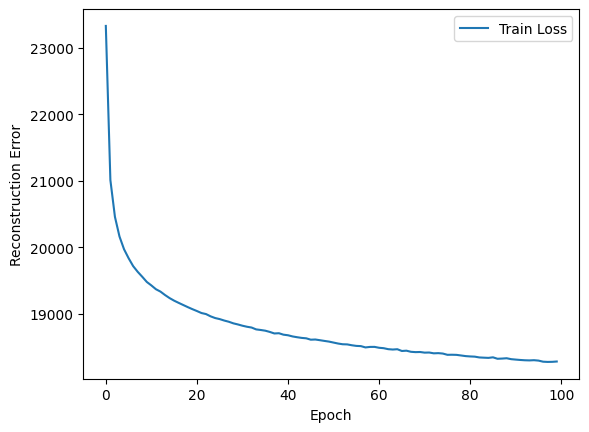

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
### TODO: fplot training loss over epochs, include labels!
plt.plot(train_loss_avg, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

Exercise 7: Evaluate on the Test Set (10 points)
-------------------------
Report average reconstruction error on the entire test test.

<font color="red"> TODO: complete VAE init (~12 lines of code) </font>

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0

### TODO: compute test_loss_avg by iterating over test set
for image_batch, _ in test_dataloader:

    image_batch = image_batch.to(device)

    # pass images through vae
    recon_images, mu, logvar = vae(image_batch)

    # compute reconstruction error
    loss = vae_loss(recon_images, image_batch, mu, logvar)

    test_loss_avg += loss.item()
    num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19060.820000


Exercise 8: Visualize Reconstructions (20 points)
--------------------------
Create a figure that shows, in a digestible format, at least 50 test images, and the reconstructions corresponding to those images. The figure should consist of two grids, the first containing the test images, the second containing the reconstructions.

<font color="red"> TODO: show images and reconstructions (>20 lines of code) </font>

Original images


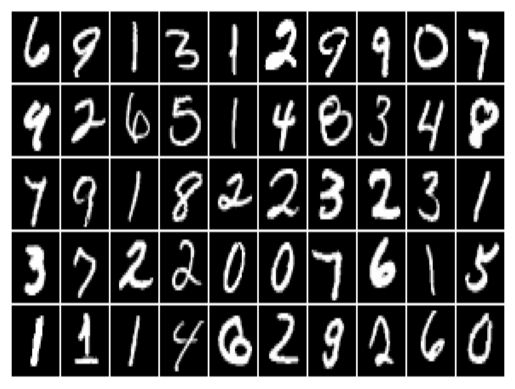

VAE reconstruction:


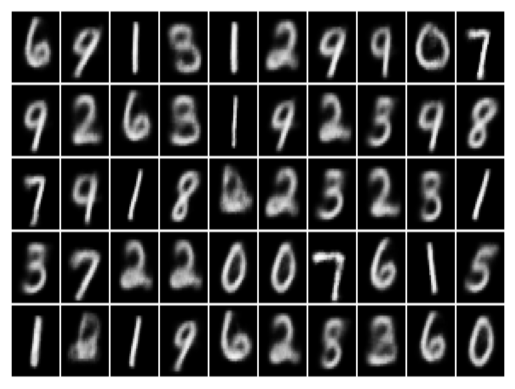

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# hint: don't forget to "clamp" if necessary
# hint: iter(test_dataloader).next() retrieves a batch
# hint: torchvision.utils.make_grid is your friend, but not necessary

# First, visualize the original images
print('Original images')
image_batch, _ = next(iter(test_dataloader))
grid_img = torchvision.utils.make_grid(image_batch[:50], nrow=10, padding=1, pad_value=1)
np_grid_img = grid_img.numpy().transpose((1, 2, 0))
plt.imshow(np_grid_img, cmap='gray', aspect='auto')
plt.axis('off')
plt.show()

# Reconstruct and visualize the images using the vae
print('VAE reconstruction:')
image_batch = image_batch.to(device)
reconstructed_images, _, _ = vae(image_batch)
reconstructed_images = reconstructed_images.clamp(0, 1)
reconstructed_grid = torchvision.utils.make_grid(reconstructed_images.cpu()[:50], nrow=10, padding=1, pad_value=1)
np_reconstructed_grid = reconstructed_grid.numpy().transpose((1, 2, 0))
plt.imshow(np_reconstructed_grid, cmap='gray', aspect='auto')
plt.axis('off')
plt.show()


Exercise 9: VAE as a Generator (20 points)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction.

<font color="red"> TODO: show 100 generated images (~10 lines of code) </font>

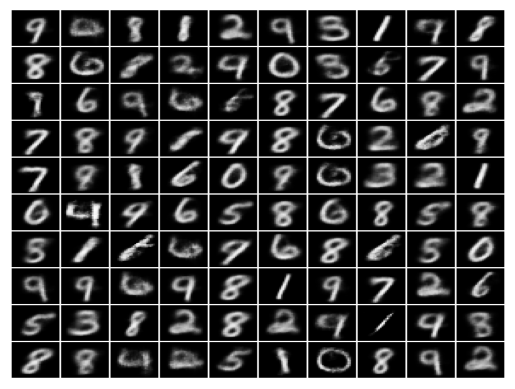

In [ ]:
vae.eval()

with torch.no_grad():
    # TODO: plot 100 "generated" digits in a grid
    # hint: these must be generated from random latent vector, not reconstructed based on some image
    latent_dim = vae.encoder.fc_mu.out_features
    random_latent_vectors = torch.randn(100, latent_dim).to(device)
    generated_images = vae.decoder(random_latent_vectors)
    generated_images = generated_images.clamp(0, 1)
    generated_grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=10, padding=1, pad_value=1)
    np_generated_grid = generated_grid.numpy().transpose((1, 2, 0))
    plt.imshow(np_generated_grid, cmap='gray', aspect='auto')
    plt.axis('off')
    plt.show()


Exercise 10: Think you can do better? (20 points)
-------------------------------------------------

Feel free to change any piece of your pipeline to try to improve performance. However, don't make the changes above, make them below. For example, if you want to define a different VAE, define it somewhere below this text block. If you define new parameters, same thing; do so below this block.

Provide evidence that the changes you made resulted in some kind of improvement. Be robust in how you "prove" this. This is a bonus assignment, so don't expect the graders to make any leaps or inferences on your behalf.

<font color="red"> TODO: improve reconstruction loss, image quality, or something else, up to you! </font>

### Improvements Made
I have increased the weight of the KL-divergence term (*variational_beta*) which should encourage the model to ensure the learned latent distribution aligns more closely with a unit Gaussian, potentially improving the quality of generated samples. The quality is improved and the each image digits are not as blurry as before.

In [ ]:
class ImprovedEncoder(nn.Module):
    def __init__(self, capacity=64):
        super(ImprovedEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=capacity, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=capacity, out_channels=capacity*2, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(in_features=capacity*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=capacity*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar


class ImprovedDecoder(nn.Module):
    def __init__(self, capacity=64):
        super(ImprovedDecoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=capacity*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=capacity*2, out_channels=capacity, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=capacity, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7)
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x


class ImprovedVariationalAutoencoder(VariationalAutoencoder):
    def __init__(self):
        super(ImprovedVariationalAutoencoder, self).__init__()
        self.encoder = ImprovedEncoder()
        self.decoder = ImprovedDecoder()


In [ ]:
def vae_loss(recon_x, x, mu, logvar, variational_beta):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kldivergence

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

improved_vae = ImprovedVariationalAutoencoder().to(device)
optimizer = torch.optim.Adam(params=improved_vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# Increase the weight of the KL-Divergence term
improved_variational_beta = 5

# Train the improved VAE
improved_vae.train()
improved_train_loss_avg = []

for epoch in range(num_epochs):
    improved_train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        recon_images, mu, logvar = improved_vae(image_batch)
        loss = vae_loss(recon_images, image_batch, mu, logvar, improved_variational_beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        improved_train_loss_avg[-1] += loss.item()
        num_batches += 1

    improved_train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, improved_train_loss_avg[-1]))


Epoch [1 / 100] average reconstruction error: 25253.535410
Epoch [2 / 100] average reconstruction error: 22958.545497
Epoch [3 / 100] average reconstruction error: 22749.205701
Epoch [4 / 100] average reconstruction error: 22606.104140
Epoch [5 / 100] average reconstruction error: 22515.817210
Epoch [6 / 100] average reconstruction error: 22429.496764
Epoch [7 / 100] average reconstruction error: 22376.673782
Epoch [8 / 100] average reconstruction error: 22324.111934
Epoch [9 / 100] average reconstruction error: 22280.463420
Epoch [10 / 100] average reconstruction error: 22247.358226
Epoch [11 / 100] average reconstruction error: 22216.371952
Epoch [12 / 100] average reconstruction error: 22181.732730
Epoch [13 / 100] average reconstruction error: 22152.300086
Epoch [14 / 100] average reconstruction error: 22136.184722
Epoch [15 / 100] average reconstruction error: 22112.018024
Epoch [16 / 100] average reconstruction error: 22088.954616
Epoch [17 / 100] average reconstruction error: 22

In [ ]:
improved_vae.eval()

improved_test_loss_avg = 0
num_batches = 0

for image_batch, _ in test_dataloader:
    image_batch = image_batch.to(device)
    recon_images, mu, logvar = improved_vae(image_batch)
    loss = vae_loss(recon_images, image_batch, mu, logvar, improved_variational_beta)

    improved_test_loss_avg += loss.item()
    num_batches += 1

improved_test_loss_avg /= num_batches
print('Improved VAE average reconstruction error: %f' % (improved_test_loss_avg))


Improved VAE average reconstruction error: 20907.629126


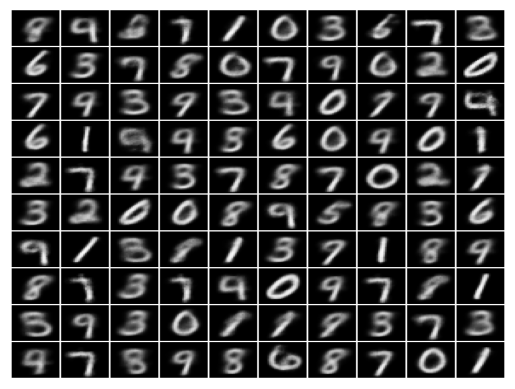

In [ ]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

improved_vae.eval()

with torch.no_grad():
    latent_dim = improved_vae.encoder.fc_mu.out_features
    random_latent_vectors = torch.randn(100, latent_dim).to(device)
    generated_images = improved_vae.decoder(random_latent_vectors)
    generated_images = generated_images.clamp(0, 1)
    generated_grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=10, padding=1, pad_value=1)
    np_generated_grid = generated_grid.numpy().transpose((1, 2, 0))
    plt.imshow(np_generated_grid, cmap='gray', aspect='auto')
    plt.axis('off')
    plt.show()


I have increased the weight of the KL-divergence term (*variational_beta*) which should encourage the model to ensure the learned latent distribution aligns more closely with a unit Gaussian, potentially improving the quality of generated samples. The quality is improved and the each image digits are not as blurry as before. For instance with the previous VAE architecture, the digit 6 and 5 were confused to be as 8, however, in this improvised version the digits 5, 6 and 8 are clear than before.